In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading the data**

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
input_path="/content/drive/MyDrive/Data"
train_data = pd.read_csv("/content/drive/MyDrive/Data/train_final.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Data/test_final.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             25000 non-null  int64 
 1   workclass       25000 non-null  object
 2   fnlwgt          25000 non-null  int64 
 3   education       25000 non-null  object
 4   education.num   25000 non-null  int64 
 5   marital.status  25000 non-null  object
 6   occupation      25000 non-null  object
 7   relationship    25000 non-null  object
 8   race            25000 non-null  object
 9   sex             25000 non-null  object
 10  capital.gain    25000 non-null  int64 
 11  capital.loss    25000 non-null  int64 
 12  hours.per.week  25000 non-null  int64 
 13  native.country  25000 non-null  object
 14  income>50K      25000 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 2.9+ MB


**Handling Missing Value**

In [ ]:
# Replace missing values in 'workclass', 'occupation', and 'native.country' with mode in train dataset
workclass_mode = train_data['workclass'].mode()[0]
occupation_mode = train_data['occupation'].mode()[0]
native_country_mode = train_data['native.country'].mode()[0]

train_data['workclass']=train_data['workclass'].replace('?', workclass_mode)
train_data['occupation']=train_data['occupation'].replace('?', occupation_mode)
train_data['native.country']=train_data['native.country'].replace('?', native_country_mode)

# Replace missing values in the test dataset using the mode from the train dataset
test_data['workclass']=test_data['workclass'].replace('?', workclass_mode)
test_data['occupation']=test_data['occupation'].replace('?', occupation_mode)
test_data['native.country']=test_data['native.country'].replace('?', native_country_mode)

**Visualizing the Categorical Variables with Respect to the Target Variabl**

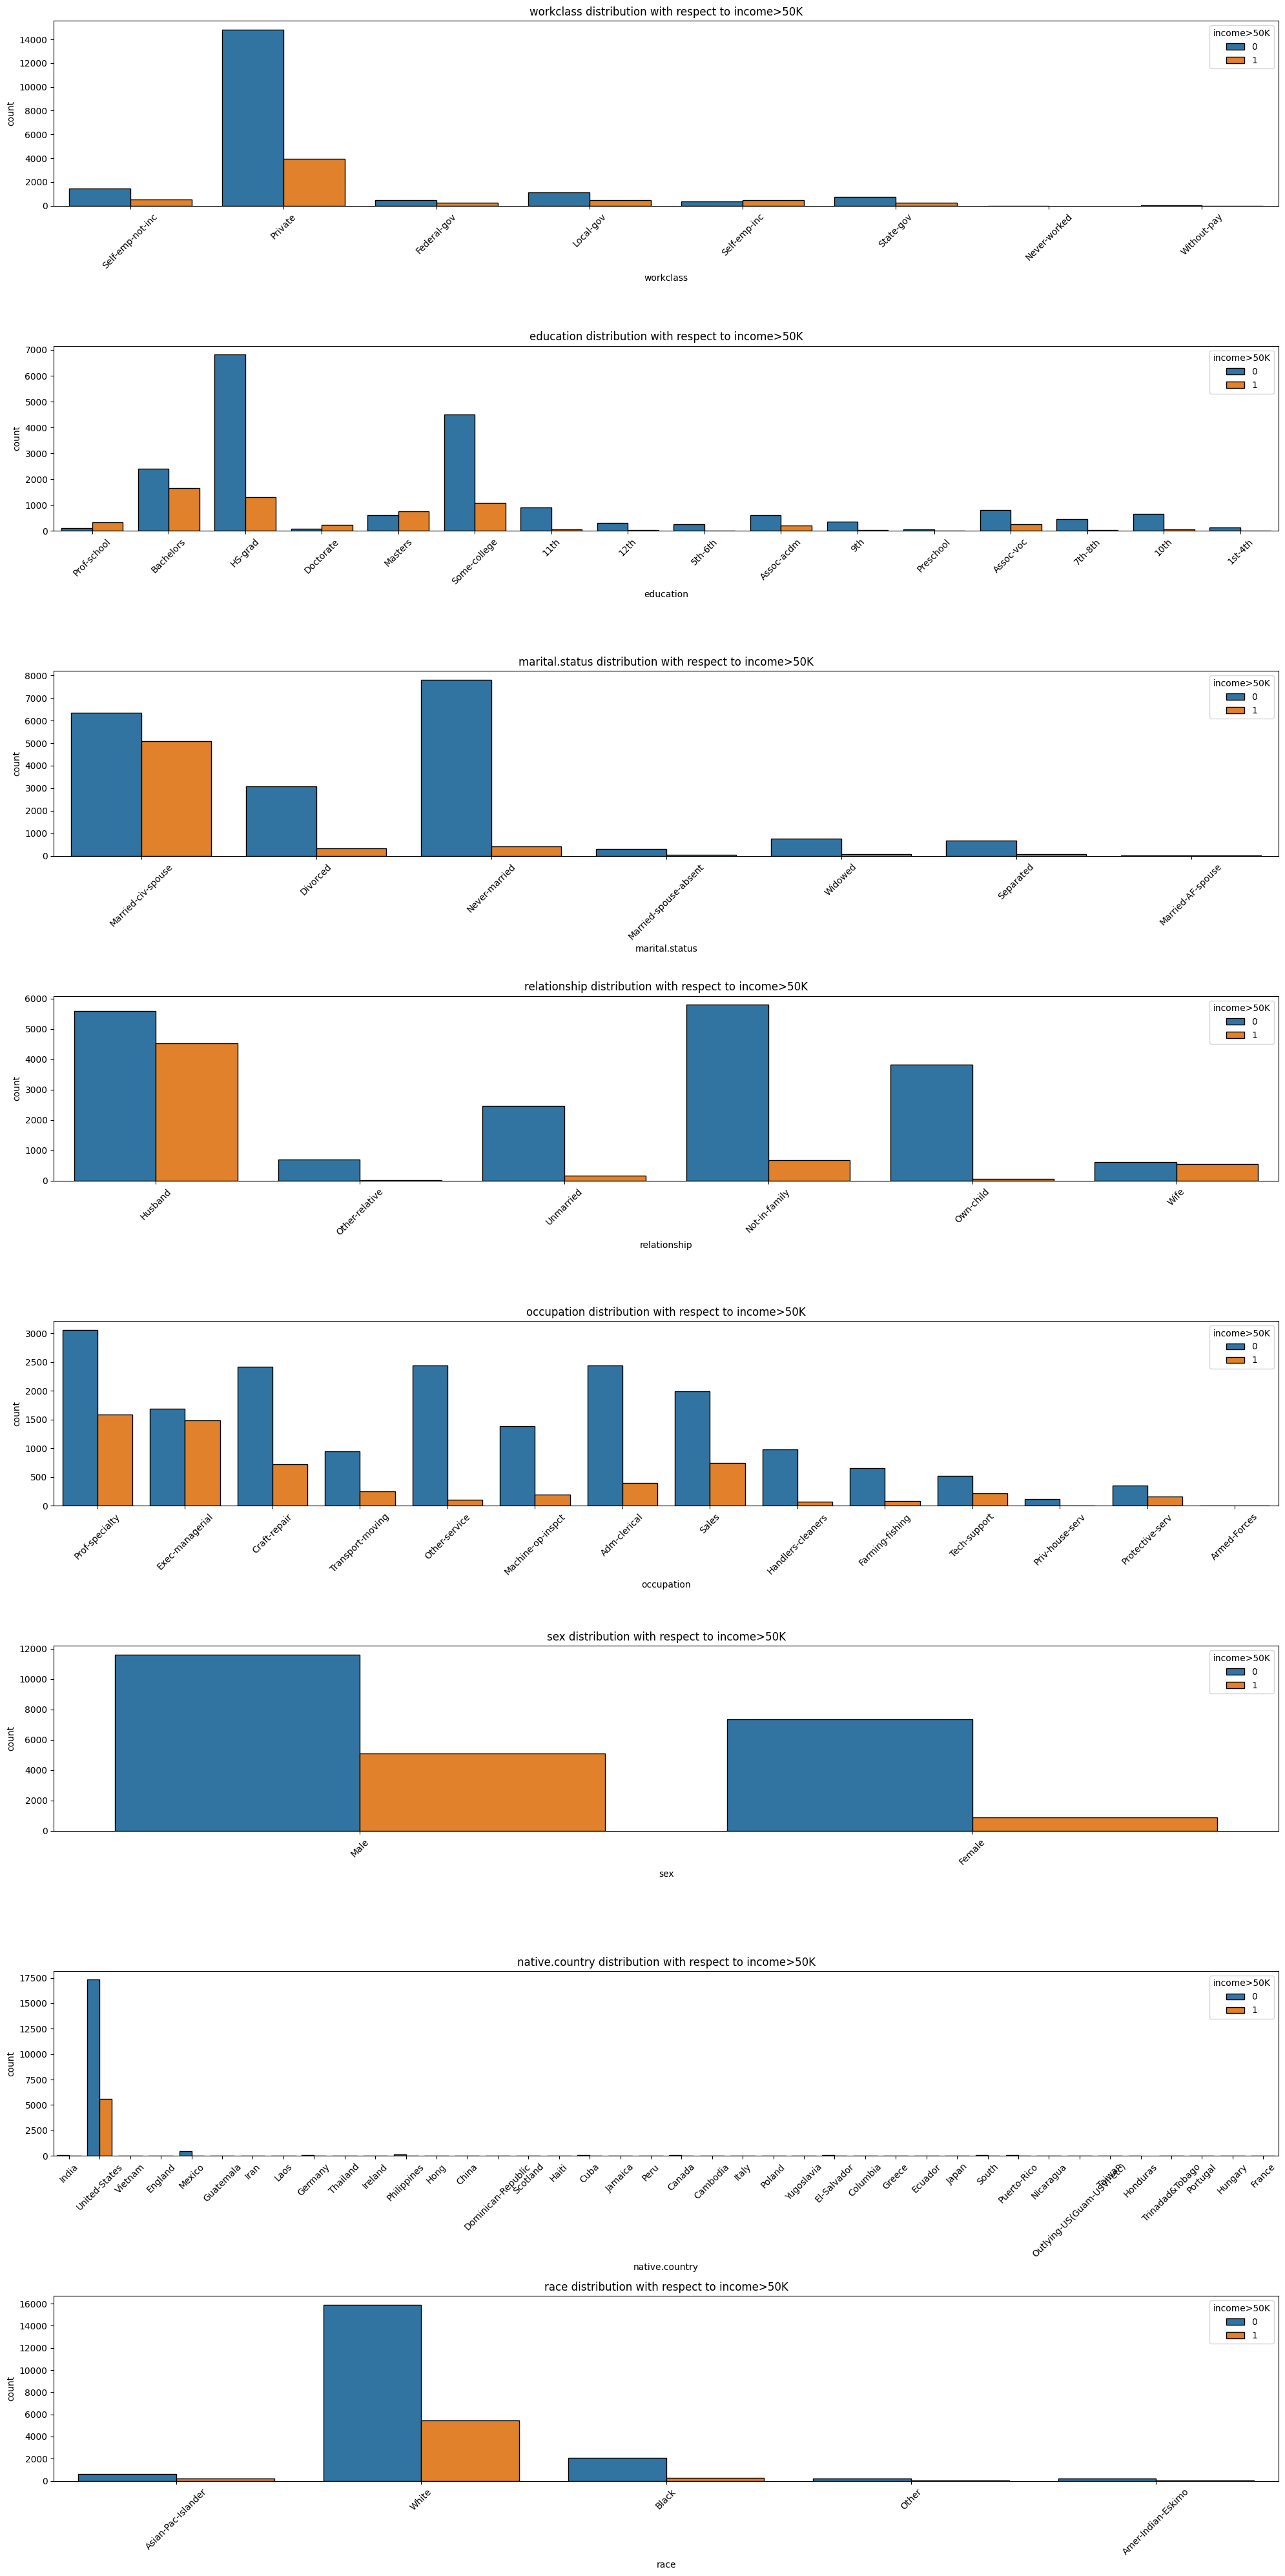

In [ ]:
def plot_categorical_with_income(df, categorical_columns, target):
    plt.figure(figsize=(20, len(categorical_columns) * 5))
    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(len(categorical_columns), 1, i)
        sns.countplot(data=df, x=col, hue=target, edgecolor='black')
        plt.title(f'{col} distribution with respect to {target}')
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.show()

# Function to plot numerical features with respect to income
def plot_numerical_with_income(df, numerical_columns, target):
    plt.figure(figsize=(15, len(numerical_columns) * 5))
    for i, col in enumerate(numerical_columns, 1):
        plt.subplot(len(numerical_columns), 2, i)
        sns.boxplot(data=df, x=target, y=col)
        plt.title(f'{col} distribution with respect to {target}')
        plt.tight_layout()
    plt.show()

# Categorical columns to visualize
categorical_columns = ['workclass', 'education', 'marital.status', 'relationship', 'occupation', 'sex', 'native.country','race']
numerical_columns = ['age', 'fnlwgt', 'education.num', 'hours.per.week', 'capital.gain', 'capital.loss']
# Plotting categorical features with respect to 'income>50K'
plot_categorical_with_income(train_data, categorical_columns, 'income>50K')

**Visualziing the Numerical Variables with respect to Target variable**

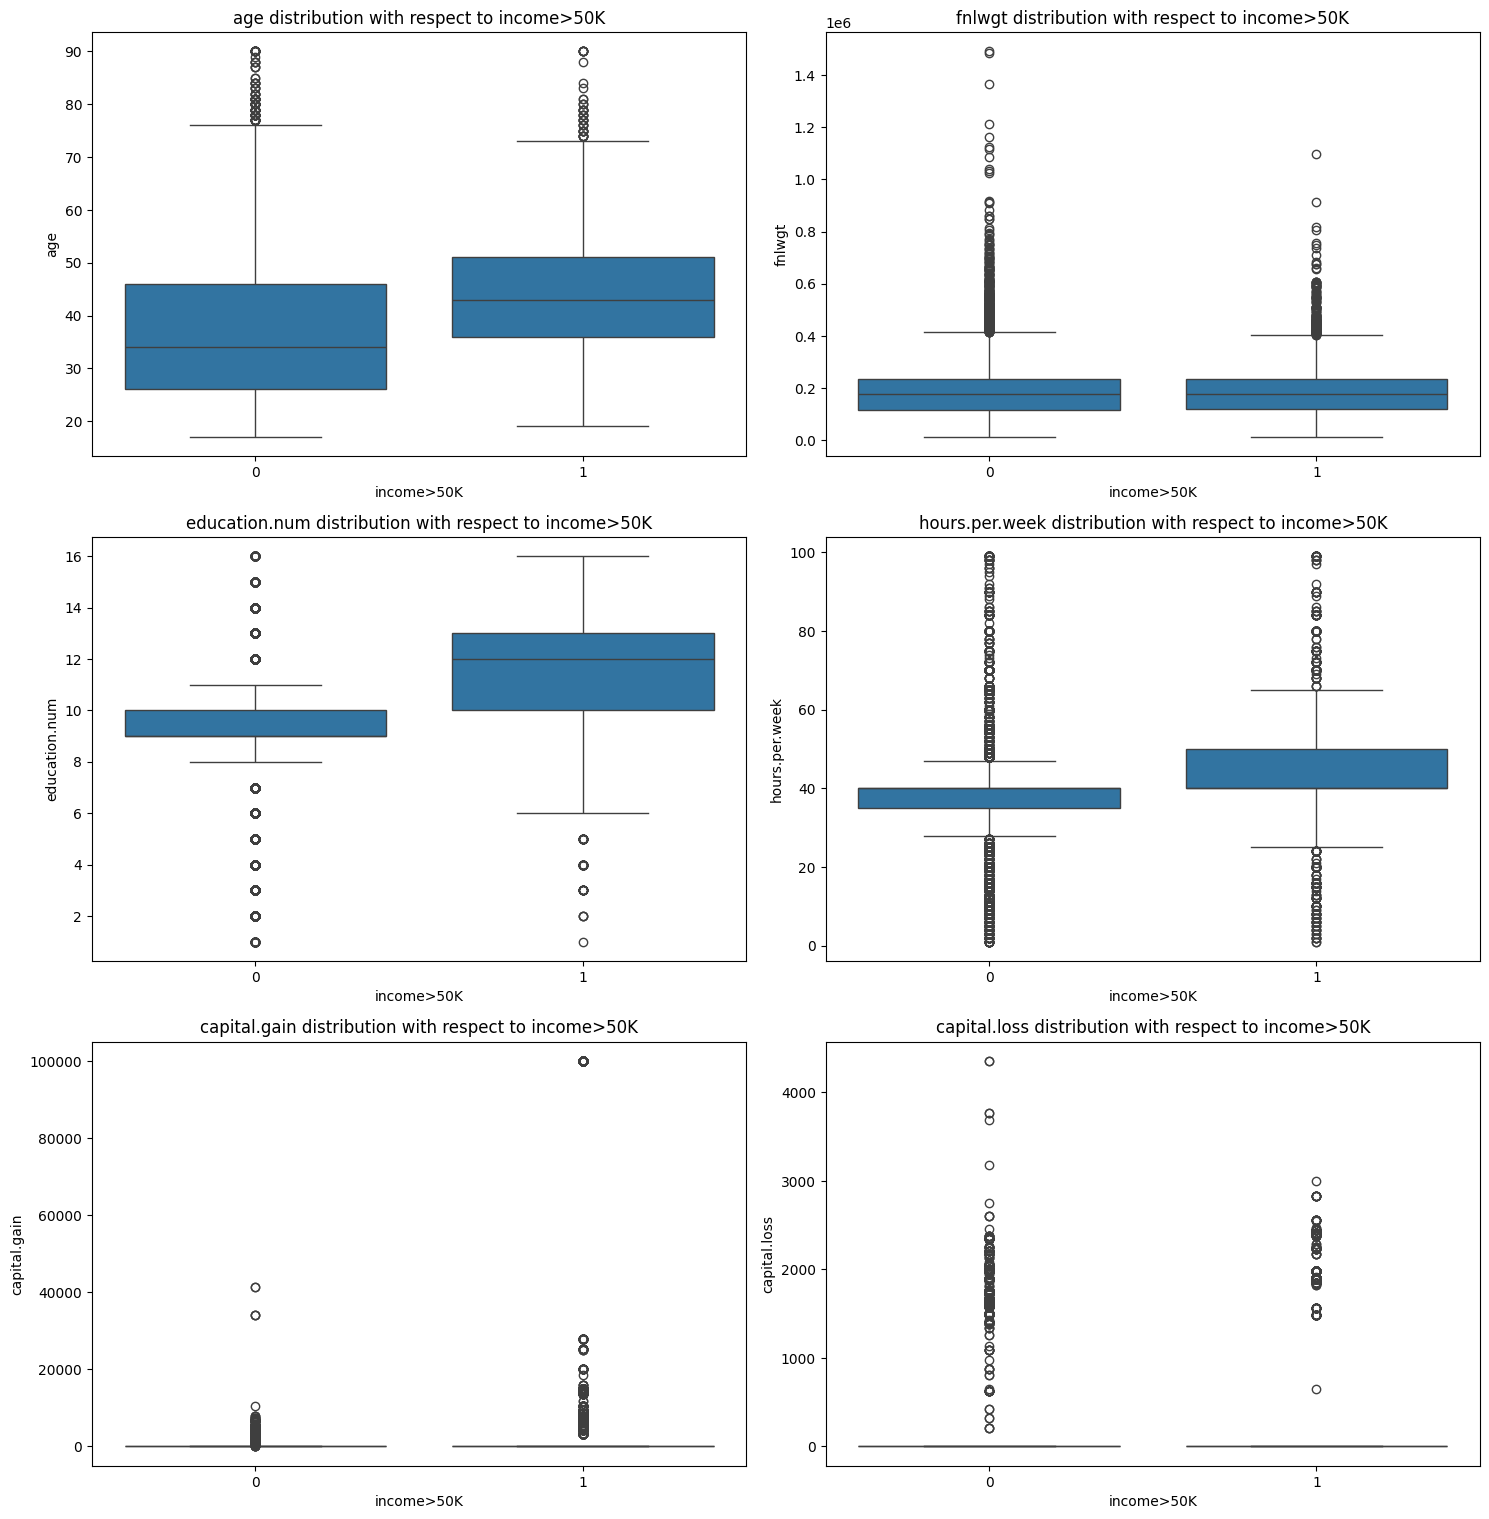

In [ ]:
plot_numerical_with_income(train_data, numerical_columns, 'income>50K')

**Handling Categorical Vairable**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Function for Frequency Encoding
def frequency_encode_columns(train, test, columns):
    for column in columns:
        freq = train[column].value_counts() / len(train)  # Calculate frequencies in the training set
        train[column] = train[column].map(freq)           # Replace the original column in the train set
        test[column] = test[column].map(freq)             # Replace the original column in the test set

        # Handle NaN values in the test set where the category wasn't present in the training set
        test[column] = test[column].fillna(0)
    return train, test

# Function for Label Encoding
def label_encode_columns(train, test, columns):
    label_encoder = LabelEncoder()  # Initialize LabelEncoder
    for column in columns:
        train[column] = label_encoder.fit_transform(train[column])  # Fit and transform train
        test[column] = label_encoder.fit_transform(test[column])        # Transform test
    return train, test

# Combined function to choose encoding type
def encode_columns(train, test, binary_columns, multi_valued_columns, encoding_type='label'):
    if encoding_type == 'label':
        # Apply Label Encoding for both binary and multi-valued columns
        train, test = label_encode_columns(train, test, binary_columns + multi_valued_columns)
    elif encoding_type == 'frequency':
        # Apply Frequency Encoding for multi-valued columns
        train, test = frequency_encode_columns(train, test, multi_valued_columns)
        # Apply Label Encoding for binary columns (as they are not multi-valued)
        train, test = label_encode_columns(train, test, binary_columns)
    else:
        raise ValueError("Invalid encoding_type. Choose 'label' or 'frequency'.")
    return train, test


binary_columns = ['sex']
multi_valued_columns = ['workclass', 'education', 'race', 'marital.status', 'relationship', 'occupation', 'native.country']

# Choose 'label' for Label Encoding or 'frequency' for Frequency Encoding
encoding_type = 'label'  # Options: 'label', 'frequency'

# Apply the encoding
train_data, test_data = encode_columns(train_data, test_data, binary_columns, multi_valued_columns, encoding_type)



**Feature Selection Using Random Forest**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import numpy as np

def find_important_features(df, target_column, variance_threshold=0.01, top_n=10):
    # Step 1: Remove low variance features
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Variance threshold to remove low variance features
    selector = VarianceThreshold(threshold=variance_threshold)
    X_var = selector.fit_transform(X)

    # Get the feature names after variance thresholding
    retained_columns = X.columns[selector.get_support()]

    # Step 2: Correlation with Target
    correlations = {}
    for col in retained_columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            correlations[col] = np.corrcoef(df[col], y)[0, 1]  # Pearson correlation

    # Sort features by absolute correlation values
    sorted_by_correlation = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    # Step 3: Model-based Feature Importance using Random Forest
    X_train, X_test, y_train, y_test = train_test_split(df[retained_columns], y, test_size=0.2, random_state=42)

    # Train a Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame to combine correlation and importance
    feature_stats = pd.DataFrame({
        'Feature': retained_columns,
        'Correlation': [correlations[col] if col in correlations else 0 for col in retained_columns],
        'Importance': feature_importances
    })

    # Rank the features based on importance
    feature_stats['Combined_Rank'] = feature_stats['Importance'].rank(ascending=False)

    # Sort by combined rank or importance
    important_features = feature_stats.sort_values('Combined_Rank').head(top_n)

    return important_features['Feature']


important_features = find_important_features(train_data, target_column='income>50K', top_n=10)
print(important_features)

2             fnlwgt
0                age
10      capital.gain
7       relationship
4      education.num
12    hours.per.week
6         occupation
5     marital.status
1          workclass
11      capital.loss
Name: Feature, dtype: object


**Classification**

**1.1 Support Vector Machine with RBF**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score ,confusion_matrix

# Assuming train_data contains both features and the target column 'income>50K'

# Separate the features and the target variable
X = train_data[important_features] # Features (drop the target column)
y = train_data['income>50K']  # Target variable

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (important for SVMs with RBF kernel)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


svm_model=SVC(kernel='rbf',C=10,gamma=0.1,probability=True,class_weight='balanced')
svm_model.fit(X_train_scaled,y_train)

# Set up the parameter grid for C and gamma
"""
param_grid = [
    {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},  # For RBF kernel

]
# Initialize GridSearchCV with the SVM model
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train_scaled, y_train)
"""

#Print the best parameters from GridSearchCV
#print("Best Parameters from Grid Search:", grid_search.best_params_)


# Use the best model to make predictions on the validation set
y_pred= svm_model.predict(X_val_scaled)

# Evaluate the best model
print("Accuracy with Tuned Parameters:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Accuracy with Tuned Parameters: 0.7956
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85      3782
           1       0.55      0.85      0.67      1218

    accuracy                           0.80      5000
   macro avg       0.75      0.82      0.76      5000
weighted avg       0.85      0.80      0.81      5000

Confusion Matrix:
 [[2939  843]
 [ 179 1039]]


**AUC Curve for SVM**

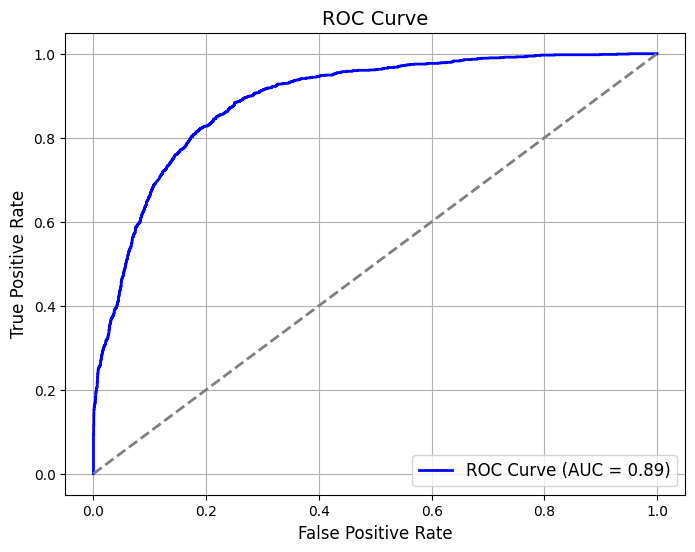

AUC Score: 0.8912989018069345


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Generate the predicted probabilities for the positive class (income > 50K)
y_prob = svm_model.predict_proba(X_val_scaled)[:, 1]  # Probability of the positive class

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, y_prob)  # False positive rate, True positive rate
roc_auc = auc(fpr, tpr)  # Compute the AUC score

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

# Print AUC score for reference
print("AUC Score:", roc_auc)


**1.2 XGBoost Classifer**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Assuming train_data contains both features and the target column 'income>50K'

# 1. Separate the features and the target variable
X = train_data.drop('income>50K', axis=1)  # Features (drop the target column)
y = train_data['income>50K']  # Target variable

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (optional but often beneficial for tree-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Calculate scale_pos_weight to handle class imbalance
# Formula: scale_pos_weight = (number of negative samples) / (number of positive samples)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize XGBoost classifier with class imbalance handling
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,gamma=0.1,learning_rate=0.2, max_depth=7, n_estimators=200)
"""
# 6. Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.3]
}
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# Initialize GridSearchCV with XGBoost model
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
# Print the best parameters
print("Best Parameters from Grid Search:", grid_search.best_params_)
# 9. Use the best model to make predictions on the validation set
"""
xgb_model.fit(X_train_scaled,y_train)
y_pred = xgb_model.predict(X_val_scaled)

# 10. Evaluate the best model
print("Accuracy with Tuned Parameters:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy with Tuned Parameters: 0.8388
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      3782
           1       0.63      0.80      0.71      1218

    accuracy                           0.84      5000
   macro avg       0.78      0.83      0.80      5000
weighted avg       0.86      0.84      0.84      5000



**AUC Curve FOR XGBoost Classifier**

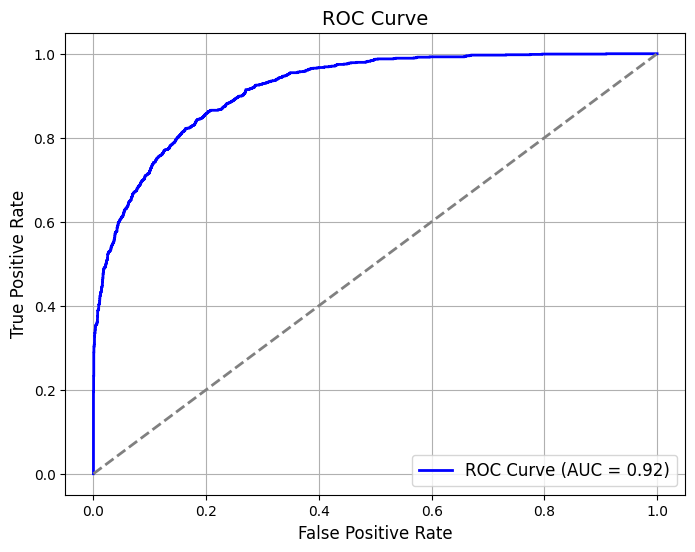

AUC Score: 0.9176449633081775


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Generate the predicted probabilities for the positive class (income > 50K)
y_prob = xgb_model.predict_proba(X_val_scaled)[:, 1]  # Probability of the positive class

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, y_prob)  # False positive rate, True positive rate
roc_auc = auc(fpr, tpr)  # Compute the AUC score

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

# Print AUC score for reference
print("AUC Score:", roc_auc)

**Random Forest Classifier**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Assuming train_data contains both features and the target column 'income>50K'

# 1. Separate the features and the target variable
X = train_data[important_features]  # Features (drop the target column)
y = train_data['income>50K']       # Target variable

# 2. Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize the data (optional for tree-based models, but can be done for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 4. Initialize and train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# 5. Make predictions on the validation set
y_pred = rf_model.predict(X_val_scaled)

# 6. Evaluate the model
print("Accuracy with Random Forest:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Accuracy with Random Forest: 0.8534
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      3782
           1       0.74      0.62      0.67      1218

    accuracy                           0.85      5000
   macro avg       0.81      0.77      0.79      5000
weighted avg       0.85      0.85      0.85      5000

Confusion Matrix:
 [[3512  270]
 [ 463  755]]


**Auc Curve for Random Forest**

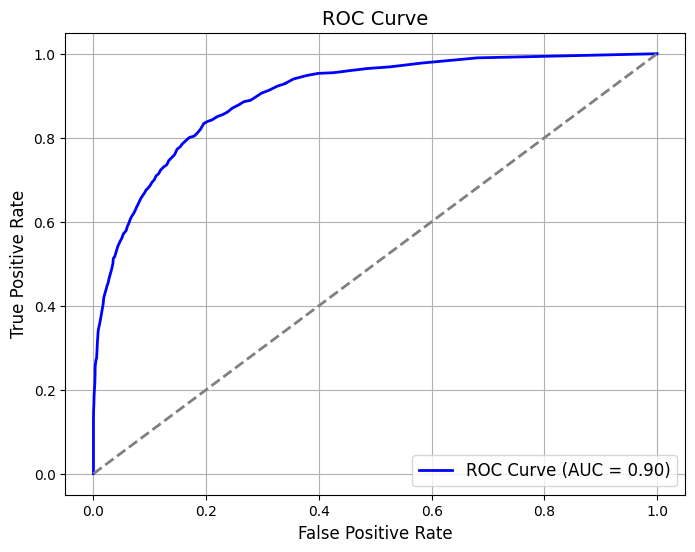

AUC Score: 0.9006305470819777


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Generate the predicted probabilities for the positive class (income > 50K)
y_prob = rf_model.predict_proba(X_val_scaled)[:, 1]  # Probability of the positive class

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val, y_prob)  # False positive rate, True positive rate
roc_auc = auc(fpr, tpr)  # Compute the AUC score

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

# Print AUC score for reference
print("AUC Score:", roc_auc)

**Artificial Neural Network**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Assuming train_data contains both features and the target column 'income>50K'

# 1. Separate the features and the target variable
X = train_data.drop('income>50K', axis=1).values  # Features as NumPy array
y = train_data['income>50K'].values  # Target as NumPy array

# 2. Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Add a dimension for compatibility

# 4. Split data into training and validation sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 5. Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output for binary classification
        )

    def forward(self, x):
        return self.model(x)

input_size = X_tensor.shape[1]
model = NeuralNetwork(input_size)

# 6. Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 8. Evaluate the model
model.eval()
y_val_pred = []
y_val_true = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_val_pred.extend(outputs.cpu().numpy())
        y_val_true.extend(targets.cpu().numpy())

y_val_pred = np.array(y_val_pred) > 0.5
y_val_true = np.array(y_val_true)

print("Accuracy:", accuracy_score(y_val_true, y_val_pred))
print("Classification Report:\n", classification_report(y_val_true, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_true, y_val_pred))


Epoch 1/100, Loss: 0.4203
Epoch 2/100, Loss: 0.3745
Epoch 3/100, Loss: 0.3647
Epoch 4/100, Loss: 0.3596
Epoch 5/100, Loss: 0.3542
Epoch 6/100, Loss: 0.3512
Epoch 7/100, Loss: 0.3525
Epoch 8/100, Loss: 0.3492
Epoch 9/100, Loss: 0.3463
Epoch 10/100, Loss: 0.3462
Epoch 11/100, Loss: 0.3452
Epoch 12/100, Loss: 0.3442
Epoch 13/100, Loss: 0.3402
Epoch 14/100, Loss: 0.3413
Epoch 15/100, Loss: 0.3455
Epoch 16/100, Loss: 0.3447
Epoch 17/100, Loss: 0.3434
Epoch 18/100, Loss: 0.3438
Epoch 19/100, Loss: 0.3415
Epoch 20/100, Loss: 0.3400
Epoch 21/100, Loss: 0.3366
Epoch 22/100, Loss: 0.3392
Epoch 23/100, Loss: 0.3387
Epoch 24/100, Loss: 0.3359
Epoch 25/100, Loss: 0.3392
Epoch 26/100, Loss: 0.3354
Epoch 27/100, Loss: 0.3369
Epoch 28/100, Loss: 0.3368
Epoch 29/100, Loss: 0.3369
Epoch 30/100, Loss: 0.3353
Epoch 31/100, Loss: 0.3343
Epoch 32/100, Loss: 0.3362
Epoch 33/100, Loss: 0.3330
Epoch 34/100, Loss: 0.3330
Epoch 35/100, Loss: 0.3329
Epoch 36/100, Loss: 0.3356
Epoch 37/100, Loss: 0.3331
Epoch 38/1

**AUC Curve for Neural Network**

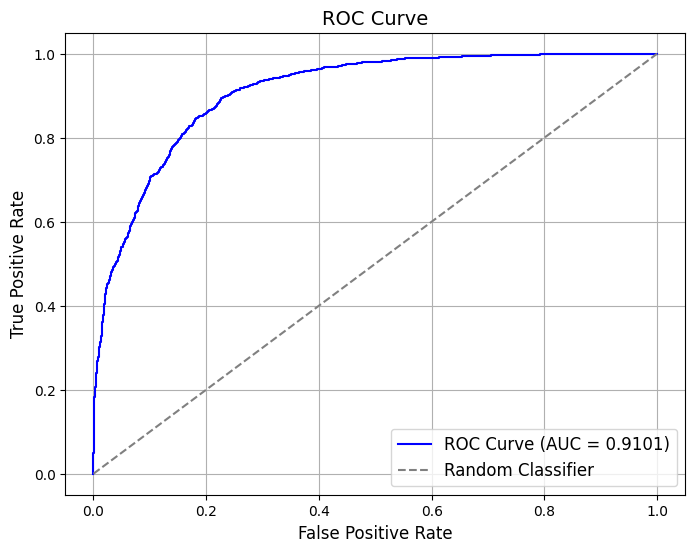

AUC Score: 0.9101


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def calculate_and_plot_auc(model, data_loader, device):

    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Get model predictions (probabilities)
            outputs = model(inputs)

            y_probs.extend(outputs.cpu().numpy())  # Predicted probabilities
            y_true.extend(targets.cpu().numpy())  # True labels

    y_probs = np.array(y_probs)
    y_true = np.array(y_true)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid()
    plt.show()

    return auc_score
auc_score = calculate_and_plot_auc(model, val_loader, device)
print(f"AUC Score: {auc_score:.4f}")

**1D Convolution Network**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
import numpy as np

# 1. Prepare the data
X = train_data[important_features].values  # Replace with selected features
y = train_data['income>50K'].values  # Target variable

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a channel dimension for 1D CNN input
X_scaled = X_scaled[:, :, np.newaxis]

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)  # Shape: [batch_size, seq_len, features]
X_tensor = X_tensor.permute(0, 2, 1)  # Change to [batch_size, features, seq_len]
print(X_tensor.shape)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Split into training and validation sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)



# 2. Define the 1D CNN model
class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear((input_size // 4) * 64, 128)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(self.bn1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = nn.ReLU()(self.bn2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout3(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout4(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Model instantiation
input_size = X_scaled.shape[1]
cnn_model = CNN1D(input_size)

# 3. Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# 4. Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


# 5. Evaluate the model
model.eval()
y_val_pred = []
y_val_true = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = cnn_model(inputs)
        y_val_pred.extend(outputs.cpu().numpy())
        y_val_true.extend(targets.cpu().numpy())

# Convert predictions to binary values
y_val_pred = (np.array(y_val_pred) > 0.5).astype(int)
y_val_true = np.array(y_val_true)

print("Accuracy:", accuracy_score(y_val_true, y_val_pred))
print("Classification Report:\n", classification_report(y_val_true, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_true, y_val_pred))


torch.Size([25000, 1, 10])
Epoch 1/100, Loss: 0.4120
Epoch 2/100, Loss: 0.3746
Epoch 3/100, Loss: 0.3693
Epoch 4/100, Loss: 0.3655
Epoch 5/100, Loss: 0.3598
Epoch 6/100, Loss: 0.3570
Epoch 7/100, Loss: 0.3540
Epoch 8/100, Loss: 0.3535
Epoch 9/100, Loss: 0.3517
Epoch 10/100, Loss: 0.3478
Epoch 11/100, Loss: 0.3464
Epoch 12/100, Loss: 0.3456
Epoch 13/100, Loss: 0.3419
Epoch 14/100, Loss: 0.3413
Epoch 15/100, Loss: 0.3420
Epoch 16/100, Loss: 0.3421
Epoch 17/100, Loss: 0.3424
Epoch 18/100, Loss: 0.3454
Epoch 19/100, Loss: 0.3428
Epoch 20/100, Loss: 0.3395
Epoch 21/100, Loss: 0.3413
Epoch 22/100, Loss: 0.3376
Epoch 23/100, Loss: 0.3324
Epoch 24/100, Loss: 0.3367
Epoch 25/100, Loss: 0.3363
Epoch 26/100, Loss: 0.3346
Epoch 27/100, Loss: 0.3353
Epoch 28/100, Loss: 0.3327
Epoch 29/100, Loss: 0.3313
Epoch 30/100, Loss: 0.3335
Epoch 31/100, Loss: 0.3338
Epoch 32/100, Loss: 0.3345
Epoch 33/100, Loss: 0.3315
Epoch 34/100, Loss: 0.3329
Epoch 35/100, Loss: 0.3328
Epoch 36/100, Loss: 0.3316
Epoch 37/1

**Auc Score of CNN-1D**

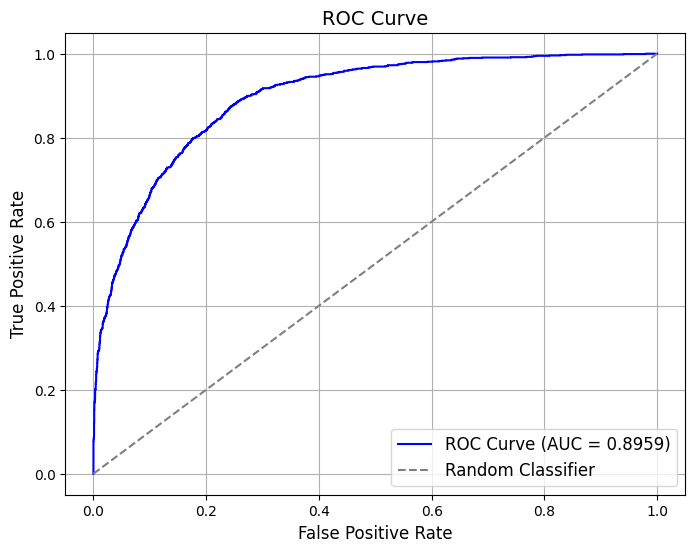

AUC Score: 0.8959


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def calculate_and_plot_auc(model, data_loader, device):

    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Get model predictions (probabilities)
            outputs = cnn_model(inputs)

            y_probs.extend(outputs.cpu().numpy())  # Predicted probabilities
            y_true.extend(targets.cpu().numpy())  # True labels

    y_probs = np.array(y_probs)
    y_true = np.array(y_true)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid()
    plt.show()

    return auc_score
auc_score = calculate_and_plot_auc(model, val_loader, device)
print(f"AUC Score: {auc_score:.4f}")

**Creating the Predictions**


**For Machine Learning Model**

In [ ]:
test_ids=test_data['ID'].values
testing_data=test_data.drop(columns=['ID'])
testing_data=test_data.drop(columns=['ID'])
testing_data=testing_data[important_features]
X_test=testing_data.to_numpy()

scaler = StandardScaler()
# Fit and transform the test data
test_data_normalized = scaler.fit_transform(X_test)

# Generate predictions on the normalized data(machine learning model)
# change the name of the model
results =svm_model.predict_proba(test_data_normalized)

#Getting the probability of income greater than >50K
predictions_machine=results[:, 1]


In [ ]:
#Saving the Submission
my_submission = pd.DataFrame({'ID': test_ids,
                             'Prediction': predictions_machine})
my_submission.to_csv('submission2.csv', index=False)

**Making the Predictions Using Deep Learning Models**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Preprocess the test data
X_test = testing_data.to_numpy()
X_test_normalized = scaler.transform(X_test)  # Use the same scaler from training
X_test_normalized = X_test_normalized[:, :, np.newaxis]  # Add channel dimension

# Step 2: Convert to PyTorch tensor
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32).permute(0, 2, 1)  # Shape: [batch_size, channels, seq_len]

# Step 3: Create DataLoader (optional, but useful for large datasets)
test_dataset = TensorDataset(X_test_tensor)  # No labels since we don't have them
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 4: Perform inference
cnn_model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)  # Get the input batch and send to device
        outputs = cnn_model(inputs)   # Predict probabilities
        predictions.extend(outputs.cpu().numpy())  # Collect predictions

# Step 5: Convert probabilities to binary predictions if needed
predictions_deep = np.array(predictions)
predictions_deep=predictions_deep.squeeze()


In [ ]:
#Saving the Submission
my_submission = pd.DataFrame({'ID': test_ids,
                             'Prediction': predictions})
my_submission.to_csv('submission_deep.csv', index=False)